Number of images in the dataset: 20210


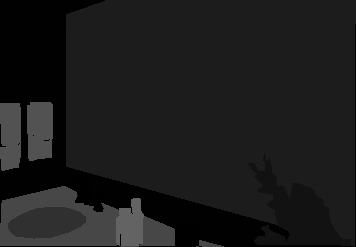

In [1]:
import os
data_folder = os.path.join("data","archive","ADEChallengeData2016")
images_num = len(os.listdir(os.path.join(data_folder, "images", "training")))
print(f"Number of images in the dataset: {images_num}")
image_train_folder = os.path.join(data_folder, "images", "training")
annotation_train_folder = os.path.join(data_folder, "annotations", "training")
from torch.utils.data import Dataset
from PIL import Image
class ADE20KDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, transform=None):
        self.image_folder = image_folder
        self.annotation_folder = annotation_folder
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_folder))
    def __len__(self):
        return len(self.image_filenames)
    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        annotation_filename = image_filename.replace(".jpg", ".png")
        image_path = os.path.join(self.image_folder, image_filename)
        annotation_path = os.path.join(self.annotation_folder, annotation_filename)
        image = Image.open(image_path).convert("RGB")
        annotation = Image.open(annotation_path)
        if self.transform:
            image = self.transform(image)
            annotation = self.transform(annotation)
        return {"image": image, "annotation": annotation}
dataset = ADE20KDataset(image_train_folder, annotation_train_folder)

index = 10
dataset[index]['image']
dataset[index]["annotation"]

info on objects and their classes in objectinfo.txt file

### reklamy:
~~board, plank  -> **ID **~~

bulletin board, notice board (308)-> **ID 145**

signboard, sign (6108) -> **ID 44**

jednak żadne z powyższych nie jest reklamą i reklama jest jako tło uznawana więc usuwania reklam nie zrobimy na tym datasecie, ale ciągle mam y 150 klas

### ludzie

- person, individual, someone, somebody, mortal, soul-> **ID 13**

In [2]:
target_mask = 13 # person is 13
import numpy as np
# all images with target_mask
images_with_target_mask = []
for i in range(len(dataset)):
    if i % 1000 == 0:
        print(i)
    annotation = np.array(dataset[i]["annotation"])
    if target_mask in annotation:
        #print("succes")
        images_with_target_mask.append(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


5069


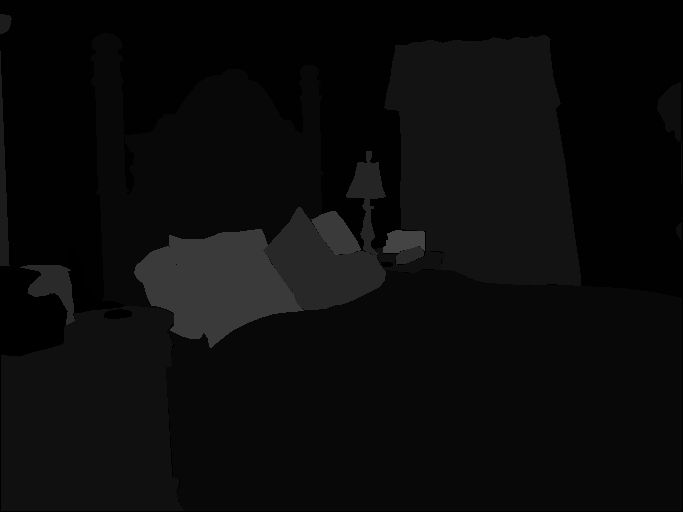

In [3]:
print(len(images_with_target_mask))
dataset[images_with_target_mask[4]]["annotation"]

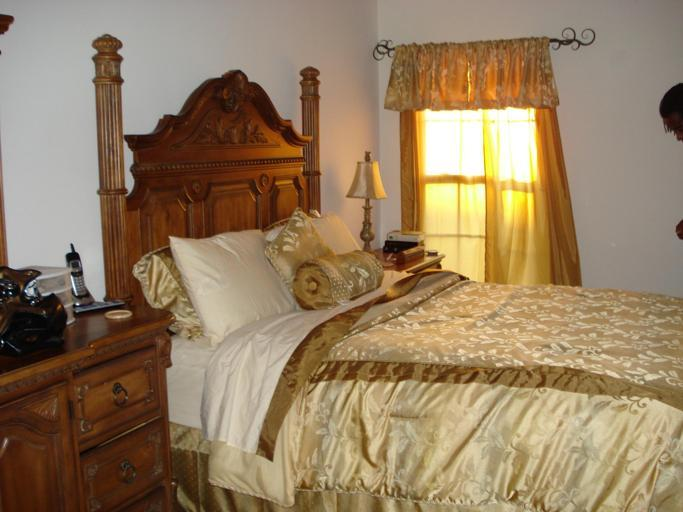

In [4]:
dataset[images_with_target_mask[4]]["image"]

In [5]:
# annot = dataset[index]["annotation"]
# annot_np = np.array(annot)
# print(annot_np[0])

In [6]:
import matplotlib.pyplot as plt
def draw_np_array(array):
    import matplotlib.pyplot as plt
    plt.imshow(array)
    plt.axis('off')
    plt.show()

In [7]:
'''pokazuje wszystkie maski obecne na obrazku'''
# for i in range(150):
#     mask =  np.array(dataset[images_with_target_mask[4]]["annotation"]) != i
#     if np.sum(mask) > 0:
#         print(f"Mask for class {i} found with {np.sum(mask)} pixels.")
#         draw_np_array(mask)

'pokazuje wszystkie maski obecne na obrazku'

In [8]:
import cv2
def enlarge_mask(mask: np.ndarray, pixels: int = 5) -> np.ndarray:
    """
    Enlarge positive areas (True or 1) in a binary mask.
    
    Args:
        mask: 2D boolean or 0/1 numpy array
        pixels: number of pixels to grow/dilate

    Returns:
        np.ndarray of same shape, dtype=bool
    """
    # ensure binary uint8
    mask_uint8 = mask.astype(np.uint8)  # 0 or 1
    mask_uint8 *= 255  # 0 or 255
    
    # create kernel for dilation
    kernel = np.ones((2*pixels+1, 2*pixels+1), np.uint8)
    
    # dilate
    dilated = cv2.dilate(mask_uint8, kernel, iterations=1)
    
    # convert back to boolean
    return dilated.astype(bool)

In [9]:
image_number = 8

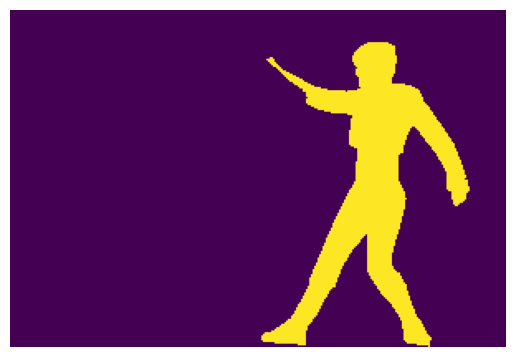

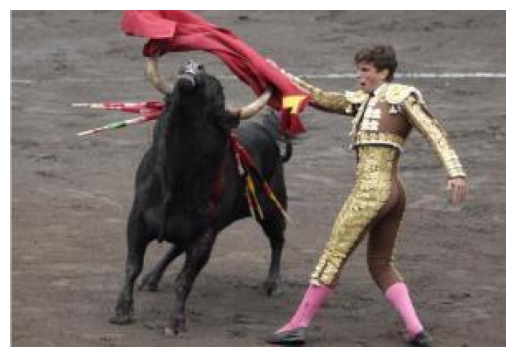

In [10]:
mask = np.array(dataset[images_with_target_mask[image_number]]["annotation"]) == target_mask
image = np.array(dataset[images_with_target_mask[image_number]]["image"]) 
draw_np_array(mask) 
draw_np_array(image)

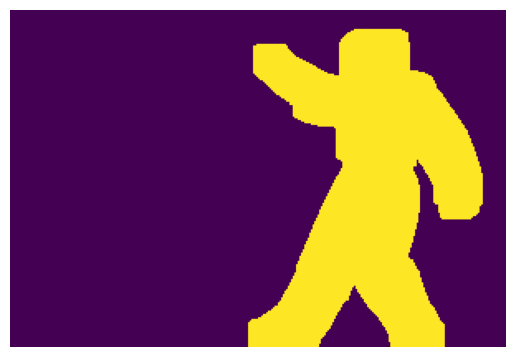

In [11]:
dilated_mask = enlarge_mask(mask, 8)
draw_np_array(dilated_mask)

# inpainting

In [12]:
from PIL import Image
# from simple_lama_inpainting import SimpleLama


In [13]:
# from simple_lama_inpainting import SimpleLama
# import inspect

# print(inspect.getfile(SimpleLama))


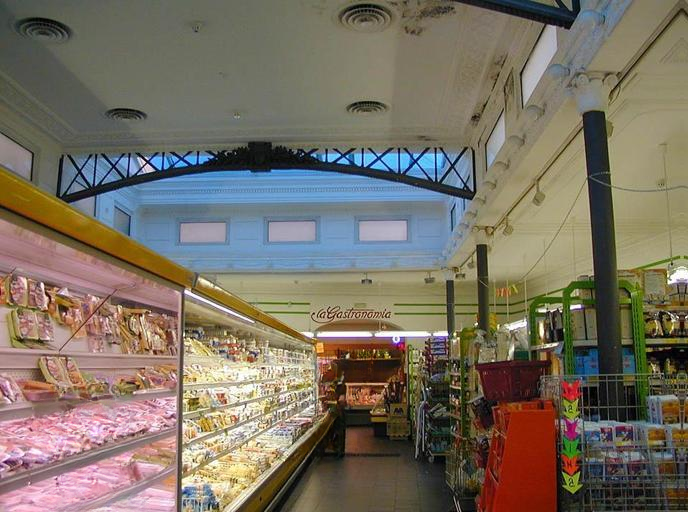

In [19]:


# initialize model
# simple_lama = SimpleLama()

from lama.simple_lama import SimpleLama

simple_lama = SimpleLama(model_path="models/big-lama.pt")


# NOTE: LaMa expects a binary mask: 255 where you want to inpaint

mask_image = Image.fromarray((dilated_mask.astype(np.uint8) * 255)).convert("L")

# run inpainting
result = simple_lama(image, mask_image)

# show or save
#result.save("inpainted_lama.png")
result


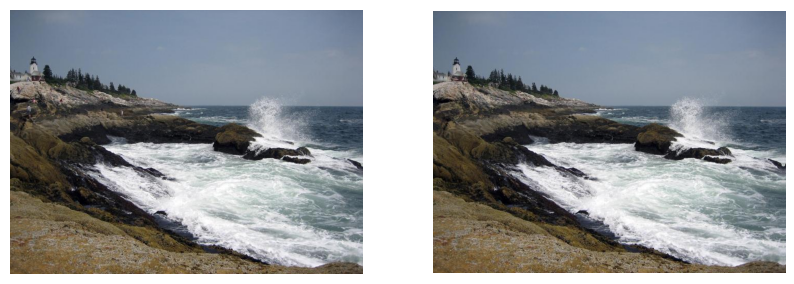

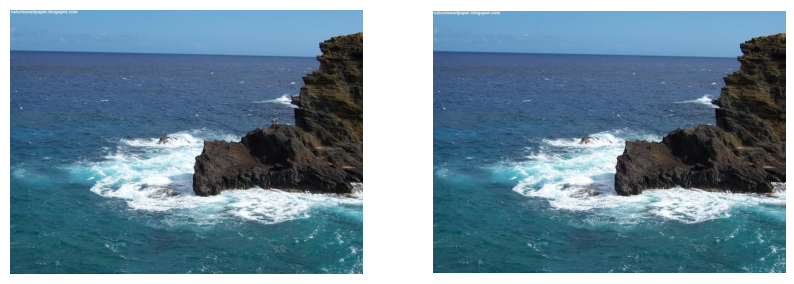

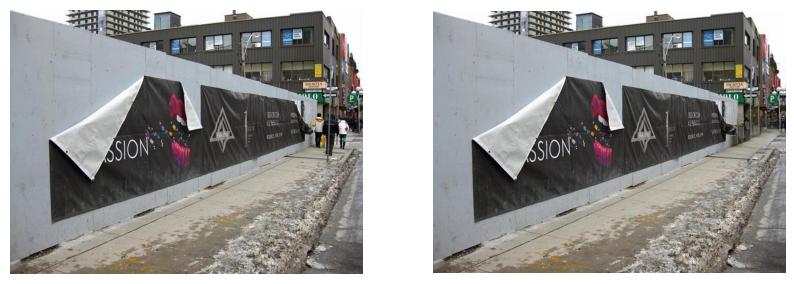

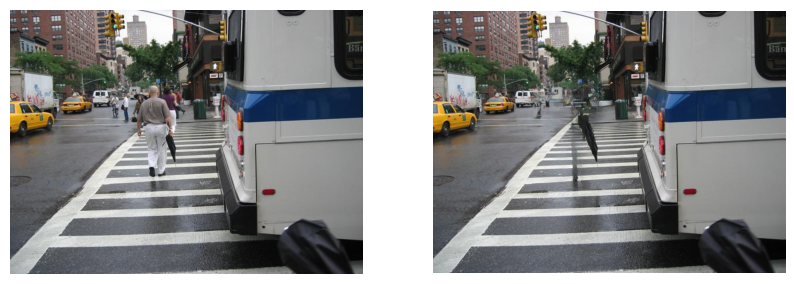

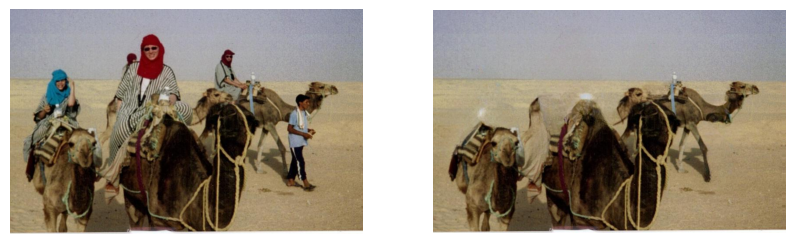

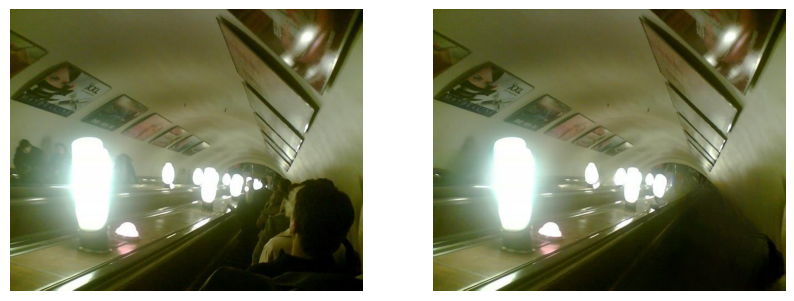

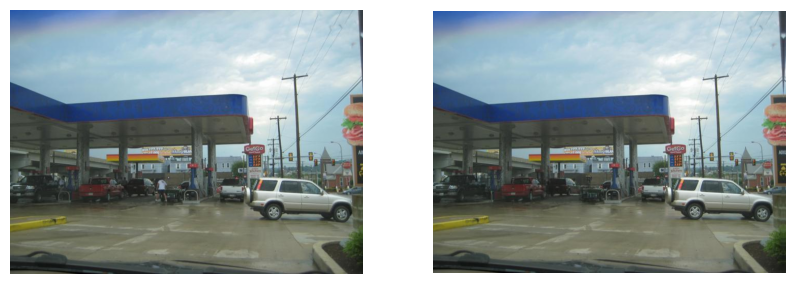

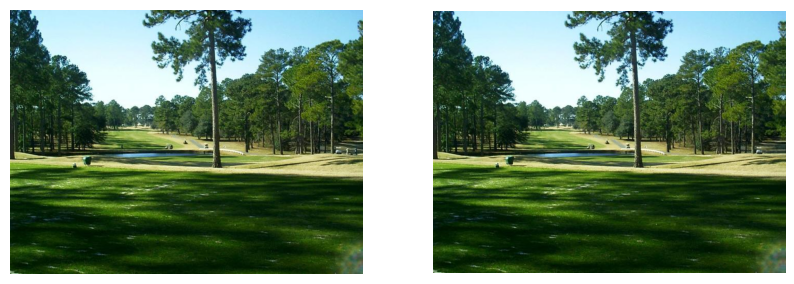

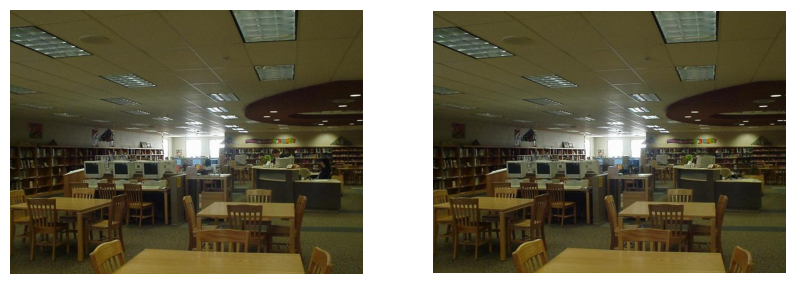

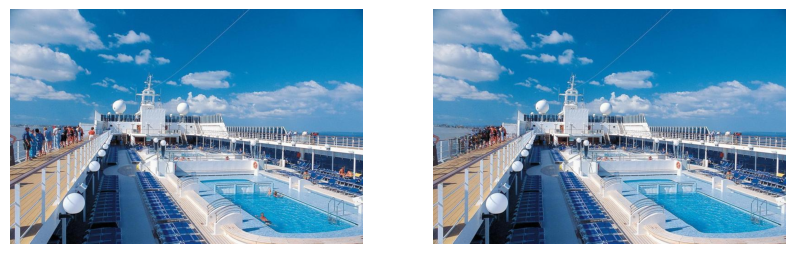

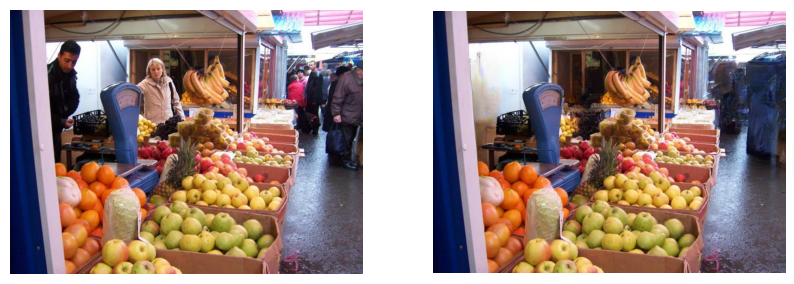

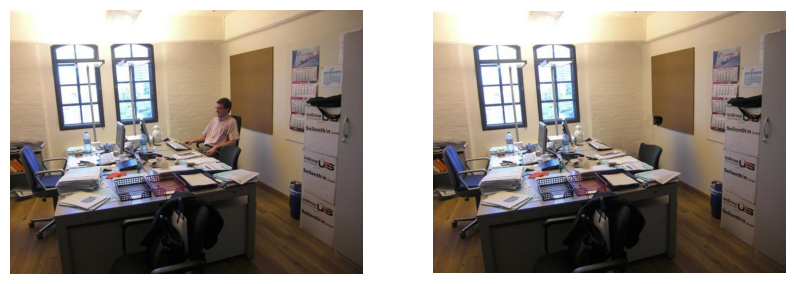

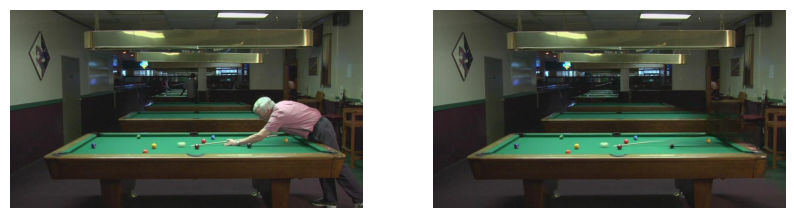

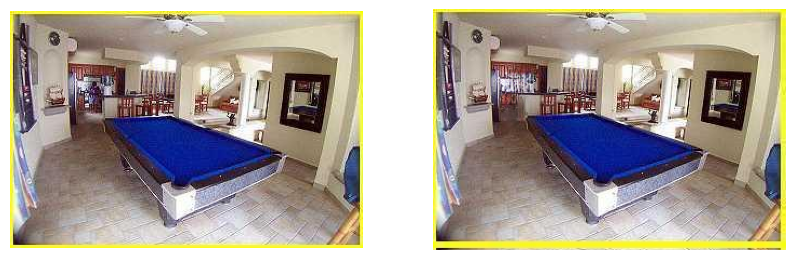

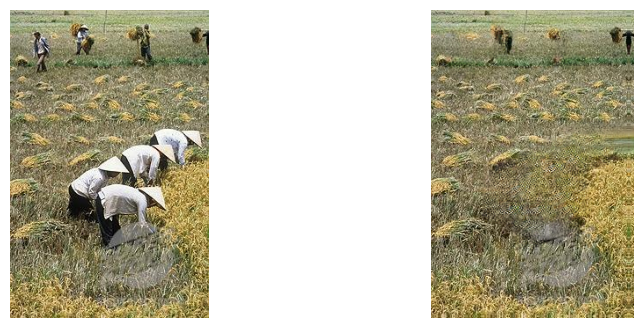

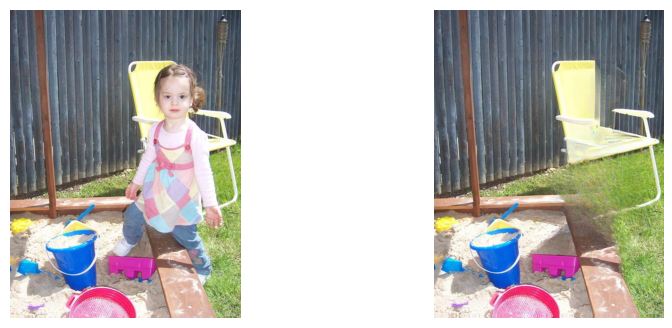

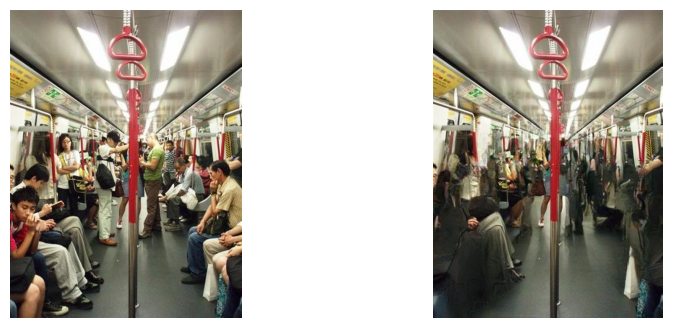

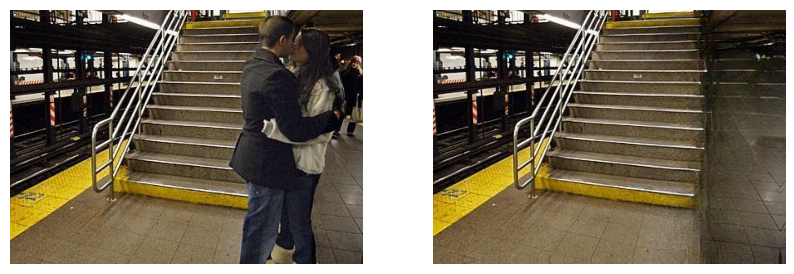

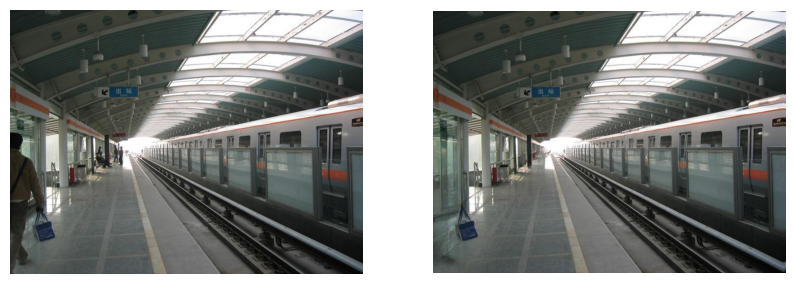

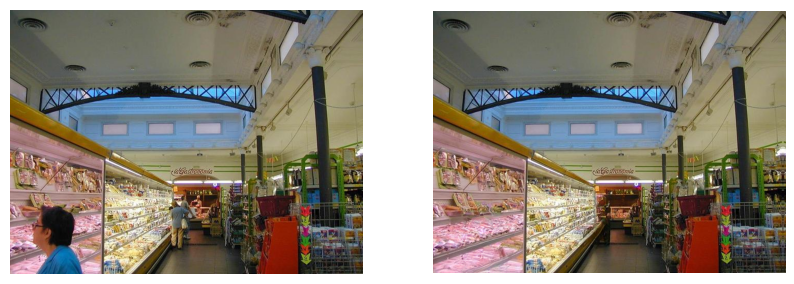

In [15]:
for i in range(10, 30):
    mask = np.array(dataset[images_with_target_mask[i]]["annotation"]) == target_mask
    image = np.array(dataset[images_with_target_mask[i]]["image"]) 
    dilated_mask = enlarge_mask(mask, 8)

    mask_image = Image.fromarray((dilated_mask.astype(np.uint8) * 255)).convert("L")

    # run inpainting
    result = simple_lama(image, mask_image)

    # show or save
    result.save("inpainted_lama.png")
    result

    # create plot where on left is original image with mask and on right is inpainted image
    #
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns
    axes[0].axis('off')
    axes[1].axis('off')

    axes[0].imshow(image)
    axes[1].imshow(result)
    plt.show()
